# Determine Scores

----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Taken from https://stackoverflow.com/a/57277932
from major_leagues import MultiColumnLabelEncoder
from sklearn import metrics

Load our data

In [2]:
data = pd.read_csv('../data/raw/nfl_games.csv')
data = data[['team1', 'team2', 'elo1', 'elo2', 'score1', 'score2', 'result1']]
data.head(10)

,team1,team2,elo1,elo2,score1,score2,result1
0,RII,STP,1503.947,1300.000,48,0,1.0
1,AKR,WHE,1503.420,1300.000,43,0,1.0
2,RCH,ABU,1503.420,1300.000,10,0,1.0
3,DAY,COL,1493.002,1504.908,14,0,1.0
4,RII,MUN,1516.108,1478.004,45,0,1.0
5,CHI,MUT,1368.333,1300.000,20,0,1.0
6,CBD,PTQ,1504.688,1300.000,48,0,1.0
7,BFF,WBU,1478.004,1300.000,32,6,1.0
8,CBD,TLM,1516.803,1300.000,42,0,1.0
9,BFF,ABU,1489.757,1292.486,51,0,1.0


We need our data split up into X and y to use in train_test_split

In [3]:
# Get our input data
X_values = data.iloc[:,:-1]
X_values = MultiColumnLabelEncoder(columns = ['team1', 'team2']).fit_transform(X_values)
X_values.head(6)

,team1,team2,elo1,elo2,score1,score2
0,84,94,1503.947,1300.000,48,0
1,0,105,1503.420,1300.000,43,0
2,80,0,1503.420,1300.000,10,0
3,28,25,1493.002,1504.908,14,0
4,84,67,1516.108,1478.004,45,0
5,15,68,1368.333,1300.000,20,0


In [4]:
# Get our results data
y_values = data['result1'].to_list()

##### Split the data up. We are using 10 to 1 for training and testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.1, random_state=42)

##### Fit our training data to a LinearRegression model

In [6]:
model = LinearRegression()
model.fit(X_train, y_train);
model.score(X_test, y_test)

0.6135630009469243

In [7]:
pred = model.predict(X_test)

##### TODO: Using all data we get 61.4% accuracy. Lets try using Linear Regression with cross_val_predict
----
##### This never worked quite right. Using cross_val_score works.

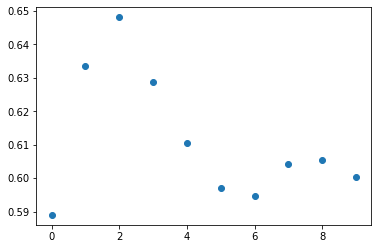

In [8]:
score = cross_val_score(model, X_values, y_values, cv=10)
plt.scatter(range(len(score)), score);

Maybe our data isn't linear? Can we find a set of data that looks linear?

In [9]:
X_values.head(5)

,team1,team2,elo1,elo2,score1,score2
0,84,94,1503.947,1300.000,48,0
1,0,105,1503.420,1300.000,43,0
2,80,0,1503.420,1300.000,10,0
3,28,25,1493.002,1504.908,14,0
4,84,67,1516.108,1478.004,45,0


Lets try elo vs points scored.

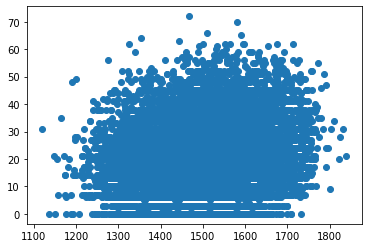

In [10]:
plt.scatter(X_values['elo1'], X_values['score1']);

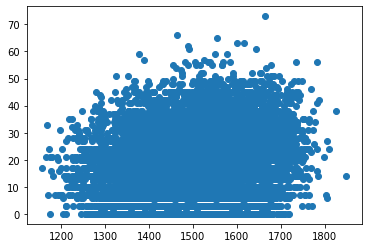

In [11]:
plt.scatter(X_values['elo2'], X_values['score2']);

Maybe looking at 1 team at a time will be clearer?

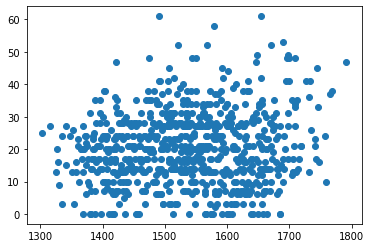

In [12]:
team15 = X_values[X_values['team1'] == 15]
plt.scatter(team15['elo1'], team15['score1']);

##### Even though higher ELO seem to mean higher scores, none of these look promising for linear regression. Lets try a non-linear model.
----
##### Lets try a KNeighborsRegressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X_train, y_train);

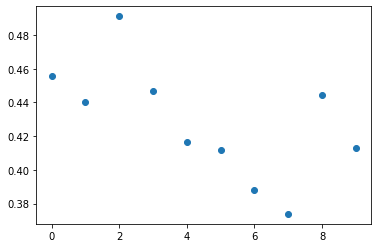

In [14]:
neigh_score = cross_val_score(neigh, X_values, y_values, cv=10)
plt.scatter(range(len(neigh_score)), neigh_score);

In [15]:
np.mean(neigh_score)

0.42820254652224216

### Ouch.

##### Playing with n_neighbors, 7 seems to be the highest possible.
----
##### Lets try RandomForest

In [16]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=2, random_state=42)
rfr.fit(X_train, y_train);

In [17]:
rfr_score = cross_val_score(rfr, X_values, y_values, cv=10)

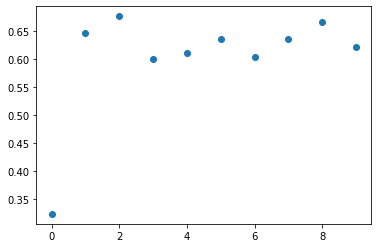

In [18]:
plt.scatter(range(len(rfr_score)), rfr_score);

In [19]:
np.mean(rfr_score)

0.6026073446747485

Not much better.

---
Lets try Gradient Boosting Regressor.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train);
gbr_score = cross_val_score(gbr, X_values, y_values, cv=10)

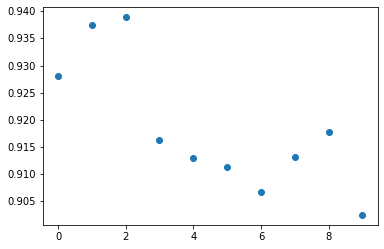

In [21]:
plt.scatter(range(len(gbr_score)), gbr_score);

In [22]:
np.mean(gbr_score)

0.9185258921130535

Given our other models, this is most likely overfitting our data.

Lets use this to predict a teams score. We are leaving in both ELO scores because it can effect the score of the winning team.

In [40]:
X_points = X_values.iloc[:,:-2]
y_points = X_values['score1'].to_list()
X_points_train, X_points_test, y_points_train, y_points_test = train_test_split(X_points, y_points, test_size=0.1, random_state=42)
gbr_pred_points = GradientBoostingRegressor(random_state=42)
gbr_pred_points.fit(X_points_train, y_points_train);
gbr_pred_points_score = cross_val_score(gbr_pred_points, X_points, y_points, cv=10)

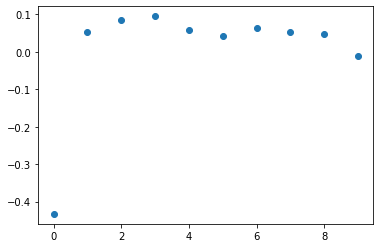

In [41]:
plt.scatter(range(len(gbr_pred_points_score)), gbr_pred_points_score);

Just using ELO?

In [42]:
X_elo = X_values[['elo1', 'elo2']]
y_elo = X_values['score1'].to_list()
X_elo_train, X_elo_test, y_elo_train, y_elo_test = train_test_split(X_elo, y_elo, test_size=0.1, random_state=42)
gbr_elo = GradientBoostingRegressor(random_state=42)
gbr_elo.fit(X_elo_train, y_elo_train);
gbr_elo_score = cross_val_score(gbr_elo, X_elo, y_elo, cv=10)

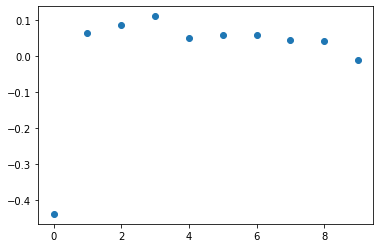

In [43]:
plt.scatter(range(len(gbr_elo_score)), gbr_elo_score);

Looks exactly the same. Using team numbers to identify each team is arbitrary if you know the elo scores.
Prehaps a better elo system would increase the accuracy. An elo system that takes player elo and status into account would far out perform our data set.

Lets predict a score anyway! Based on both teams elo score.

In [51]:
elo_test = [[1500.000, 1410.000]]

In [52]:
gbr_elo.predict(elo_test)

array([22.40155486])

Team 1 would score 22.4 points. Kind of cool!?